<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor_editor_40epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import skimage.transform
import torchvision.models as models

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])),\
               torch.from_numpy(male)

In [6]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])),\
               torch.from_numpy(male)

In [7]:
state_model = torch.load('/content/drive/My Drive/Project_Boneage/model-weight/model_1.pth')
state_model

{'epoch': 20,
 'train_loss': [28.353672330379336,
  19.710847054320194,
  19.51972219580259,
  16.29548190658947,
  15.50649901241298,
  14.998880133864493,
  13.418039646991513,
  12.62556178687756,
  11.683637718728496,
  10.551020275444667,
  11.090826994635924,
  11.151380214214072,
  9.43952403048509,
  9.9742263734937,
  8.458766399670786,
  7.828151191525706,
  8.212304508225682,
  10.175536312299519,
  9.632327163577209,
  5.287516447717074],
 'val_loss': [27.749473292705126,
  16.635473862342245,
  15.473569759168862,
  14.952480410337062,
  14.424107741554623,
  14.562585181593033,
  13.791616215549167,
  13.063095126096107,
  12.964469003324773,
  12.828109000405451,
  13.160015021456244,
  13.378300669675513,
  12.299280365422602,
  13.07167924074644,
  12.177992400209318,
  11.75570358319044,
  12.545062198853143,
  14.265497366204208,
  12.914326647892374,
  11.333223239568529],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-0.7045,  0.3546,  0.22

In [8]:
# class BoneAgePredictor(nn.Module):
#     def __init__(self):
#         super(BoneAgePredictor, self).__init__()
#         # Layer 1
#         self.conv1 = nn.Conv2d(1, 16, 3)
#         nn.init.kaiming_normal_(self.conv1.weight)
#         self.batch1 = nn.BatchNorm2d(16)
#         # Layer 2
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         nn.init.kaiming_normal_(self.conv2.weight)
#         self.batch2 = nn.BatchNorm2d(32)
#         # Layer 3
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         nn.init.kaiming_normal_(self.conv3.weight)
#         self.batch3 = nn.BatchNorm2d(64)
#         # Layer 4
#         self.conv4 = nn.Conv2d(64, 128, 3)
#         nn.init.kaiming_normal_(self.conv4.weight)
#         self.batch4 = nn.BatchNorm2d(128)
#         # Layer 5
#         self.conv5 = nn.Conv2d(128, 128, 3)
#         nn.init.kaiming_normal_(self.conv5.weight)
#         self.batch5 = nn.BatchNorm2d(128)
#         # Fully connected
#         self.fc1 = nn.Linear(4609, 68)
#         self.fc2 = nn.Linear(69, 1)
#         #self.fc2 = nn.Linear(64, 1)
    
        

#     def forward(self, x, m):
#         # Layer 1
#         x = F.relu(self.batch1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         # Layer 2
#         x = F.relu(self.batch2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         # Layer 3
#         x = F.relu(self.batch3(self.conv3(x)))
#         x = F.max_pool2d(x, 2)
#         # Layer 4
#         x = F.relu(self.batch4(self.conv4(x)))
#         x = F.max_pool2d(x, 2)
#         # Layer 5
#         x = F.relu(self.batch5(self.conv5(x)))
#         x = F.max_pool2d(x, 2)
        
#         # Pooling
#         x = x.view(-1,4608)
#         x = torch.cat((x,m), axis = 1)
#         x = self.fc1(x)
#         x = torch.cat((x,m), axis = 1)
#         x = self.fc2(x)
#         #x = torch.cat((x,m), axis = 1)
#         #x = self.fc3(x)
#         return x

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
#testing_data_loader = torch.utils.data.DataLoader(
    #BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    #batch_size=32, shuffle=True, **kwargs)

In [12]:
device

device(type='cpu')

In [13]:
!git clone https://github.com/kittimaxz/Project_BoneAge.git

Cloning into 'Project_BoneAge'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 518 (delta 28), reused 0 (delta 0), pack-reused 446
Receiving objects: 100% (518/518), 124.08 MiB | 28.98 MiB/s, done.
Resolving deltas: 100% (252/252), done.
Updating files: 100% (54/54), done.


In [14]:
!cd Project_BoneAge

In [15]:
from Project_BoneAge.model.models import BoneAgePredictor

In [16]:
model = BoneAgePredictor()
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [17]:
model.load_state_dict(state_model,strict=False)
print(model)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [18]:
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [19]:
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)
scheduler

In [20]:
train_losses = []
val_losses = []
for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_2.pth')


 Train set: Average loss: 23.4434


 Validation set: Average loss: 20.6840


 Train set: Average loss: 21.0546


 Validation set: Average loss: 18.9964


 Train set: Average loss: 18.8579


 Validation set: Average loss: 17.4159


 Train set: Average loss: 17.4336


 Validation set: Average loss: 15.8506


 Train set: Average loss: 16.8625


 Validation set: Average loss: 15.7522


 Train set: Average loss: 14.8135


 Validation set: Average loss: 14.1191


 Train set: Average loss: 13.4881


 Validation set: Average loss: 13.1519


 Train set: Average loss: 13.2833


 Validation set: Average loss: 13.2071


 Train set: Average loss: 12.5030


 Validation set: Average loss: 13.3571


 Train set: Average loss: 12.6913


 Validation set: Average loss: 13.7103

Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.

 Train set: Average loss: 10.2379


 Validation set: Average loss: 12.0995


 Train set: Average loss: 10.0237


 Validation set: Average loss: 12.1863


 Train set: A

In [21]:
checkpoint = torch.load('model_2.pth')
checkpoint

{'epoch': 20,
 'train_loss': [23.44341316264736,
  21.054554265015,
  18.857887218912808,
  17.43359086733056,
  16.862513410311315,
  14.81349125337596,
  13.48807753329353,
  13.283296680932523,
  12.502983810904242,
  12.691336327117124,
  10.237862994477325,
  10.023749129270488,
  10.147624993303012,
  9.628889686750082,
  8.926247990253081,
  8.7835093004898,
  9.084042637137145,
  8.824813097907384,
  8.353344826835839,
  8.154140852407227],
 'val_loss': [20.683963445894875,
  18.996408690922227,
  17.41589824969952,
  15.850577176704377,
  15.752221418315697,
  14.119144497174862,
  13.151862650424313,
  13.207096314638214,
  13.357085661317129,
  13.710318774859363,
  12.099520920005514,
  12.186290163165705,
  12.48603814750508,
  12.334498176302445,
  12.025972395071806,
  11.957343117383433,
  12.337396039365304,
  12.268437324300066,
  12.144029730752193,
  12.183136676059272],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-1.3701e-01, -3.1951e-01,

In [22]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [23]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [24]:
epoch = checkpoint['epoch']
epoch

20

In [25]:
train_loss = checkpoint['train_loss']
train_loss

[23.44341316264736,
 21.054554265015,
 18.857887218912808,
 17.43359086733056,
 16.862513410311315,
 14.81349125337596,
 13.48807753329353,
 13.283296680932523,
 12.502983810904242,
 12.691336327117124,
 10.237862994477325,
 10.023749129270488,
 10.147624993303012,
 9.628889686750082,
 8.926247990253081,
 8.7835093004898,
 9.084042637137145,
 8.824813097907384,
 8.353344826835839,
 8.154140852407227]

In [26]:
val_loss = checkpoint['val_loss']
val_loss

[20.683963445894875,
 18.996408690922227,
 17.41589824969952,
 15.850577176704377,
 15.752221418315697,
 14.119144497174862,
 13.151862650424313,
 13.207096314638214,
 13.357085661317129,
 13.710318774859363,
 12.099520920005514,
 12.186290163165705,
 12.48603814750508,
 12.334498176302445,
 12.025972395071806,
 11.957343117383433,
 12.337396039365304,
 12.268437324300066,
 12.144029730752193,
 12.183136676059272]

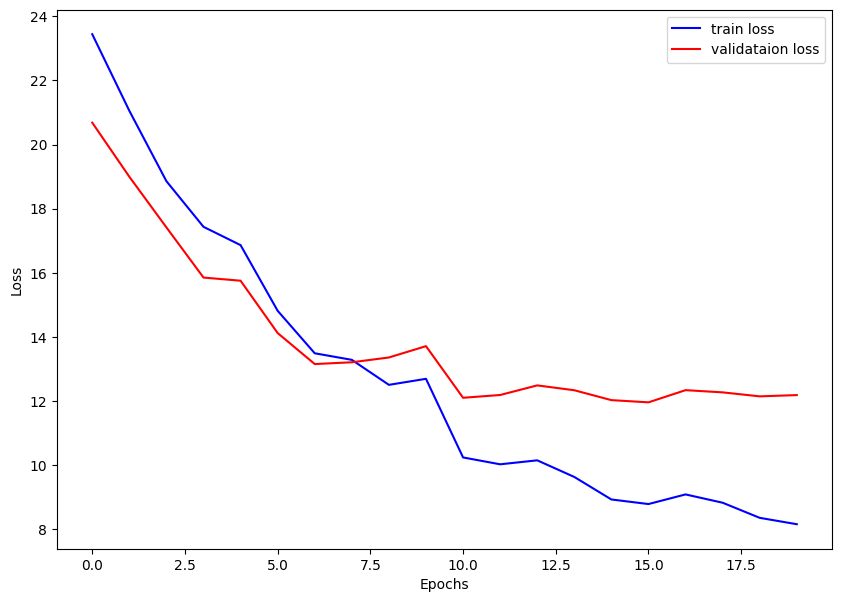

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [29]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)